In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
global DATA_GENERATED_PATH

DATA_GENERATED_PATH = 'data_generated/'

DATA_GENERATED_PATH_PROJECT = DATA_GENERATED_PATH + 'XGB/'

## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [3]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)


2023-04-12 05:48:47.894647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 2.12.0
TensorFlow version: 2.12.0


In [4]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
import nltk


In [5]:
# Load data
df = pd.read_csv("data/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing df.

### Exploration

In [6]:
df.shape
df.head()
df.tail()
df.isnull().sum()
df.nunique()

(404290, 6)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64

In [7]:
# print them in a txt file names EDA.txt
with open(DATA_GENERATED_PATH + "EDA.txt", "w") as f:
    f.write("\n\nShape of the data: \n" + str(df.shape) + "\n\n")
    f.write("\n\nFirst 5 rows of the data: \n" + "\n" + str(df.head()) + "\n\n")
    f.write("\n\nLast 5 rows of the data: \n" + "\n" + str(df.tail()) + "\n\n")
    f.write("\n\nNumber of missing values in each column: \n" + "\n" + str(df.isnull().sum()) + "\n\n")
    f.write("\n\nNumber of unique values in each column: \n" + "\n" + str(df.nunique()) + "\n\n")
    # f.write("Number of tweets in each class: " + "\n" + str(df.target.value_counts()) + "\n")
    # f.write("Percentage of tweets in each class: " + "\n" + str(df.target.value_counts(normalize=True)) + "\n")
    
    
    
    

35

878

1046

167

196

Shape of the data:
(404290, 6)

First 5 rows of the data:
   id  qid1  qid2                                          question1   
0   0     1     2  What is the step by step guide to invest in sh...  \
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  

Last 5 rows of the data:
            id    qid1    qid2   
404285  404285  433578  379845  \
4

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='is_duplicate', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Duplicate Questions')

Text(0.5, 0, 'Is Duplicate')

Text(0, 0.5, 'Frequency')

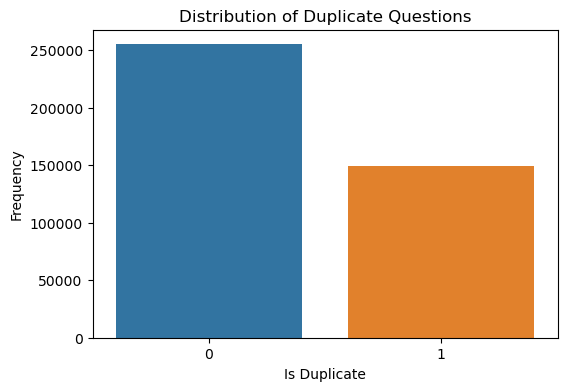


Percentage of duplicate questions: 36.92%


In [8]:
# Print the shape of the data
print("Shape of the data:")
print(df.shape)

# Print the first 5 rows of the data
print("\nFirst 5 rows of the data:")
print(df.head())

# Print the last 5 rows of the data
print("\nLast 5 rows of the data:")
print(df.tail())

# Print the number of missing values in each column
print("\nNumber of missing values in each column:")
print(df.isnull().sum())

# Print the number of unique values in each column
print("\nNumber of unique values in each column:")
print(df.nunique())

# Visualize the distribution of duplicate questions
plt.figure(figsize=(6, 4))
sns.countplot(x="is_duplicate", data=df)
plt.title("Distribution of Duplicate Questions")
plt.xlabel("Is Duplicate")
plt.ylabel("Frequency")
plt.show()

# Calculate and print the percentage of duplicate questions
duplicate_percentage = df["is_duplicate"].mean() * 100
print(f"\nPercentage of duplicate questions: {duplicate_percentage:.2f}%")

# Remove rows with missing values
df_1= df.dropna()

In [9]:
df_1.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [10]:
# Text preprocessing functions
def tokenize(text):
    # Tokenize text
    return nltk.word_tokenize(text)

def remove_stopwords(text):
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    return [word for word in text if word not in stop_words]

def remove_punctuation(text):
    # Remove punctuation
    return [word for word in text if word.isalnum()]

def normalize(text):
    # Convert to lowercase
    return [word.lower() for word in text]

def stemming(text):
    # Stemming
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]


In [11]:
# Cleaning
def clean_text(text):
    text = tokenize(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = normalize(text)
    text = stemming(text)
    return ' '.join(text)

In [12]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/ds/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /Users/ds/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to /Users/ds/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# df.dropna(subset=['question1', 'question2'], inplace=True)

# df['question1_cleaned'] = df['question1'].apply(clean_text)
# df['question2_cleaned'] = df['question2'].apply(clean_text)

In [14]:
# # save the df 
# df.to_csv(DATA_GENERATED_PATH + "cleaned_data.csv", index=False)

# df_cleaned = df.copy()

In [15]:
# # save as parquet
# df_cleaned.to_parquet(DATA_GENERATED_PATH + "cleaned_data.parquet", index=False)

In [16]:
# read the parquet
df = pd.read_parquet(DATA_GENERATED_PATH + "cleaned_data.parquet")

In [17]:
# # read the cleaned data
# df = pd.read_csv(DATA_GENERATED_PATH + "cleaned_data.csv")

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

#### XGBoost V1: GridSearch

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from joblib import dump, load

# Text preprocessing functions
# ... (same as before)

# Cleaning
# ... (same as before)

# Load and preprocess the data
# ... (same as before)


# Combine the questions
df['combined_questions'] = df['question1_cleaned'] + ' ' + df['question2_cleaned']
y = df['is_duplicate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['combined_questions'], y, test_size=0.2, random_state=42)

# Create the XGBoost model with a preprocessing pipeline
xgb_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=10)),
    ('xgb', XGBClassifier(random_state=42))
])

# Hyperparameters to tune
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(df['combined_questions'], y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_xgb_pipeline = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", class_report)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time= 2.2min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time= 2.2min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time= 2.2min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time= 2.2min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time= 2.2min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time= 4.0min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time= 4.0min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time= 4.0min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time= 3.8min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time= 3.7min
[CV

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=10)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      impo...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [50, 100, 200]},
             verbose=2)

Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Accuracy: 0.7714017165895768
Confusion Matrix:
 [[46436  4590]
 [13894 15938]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83     51026
           1       0.78      0.53      0.63     29832

    accuracy                           0.77     80858
   macro avg       0.77      0.72      0.73     80858
weighted avg       0.77      0.77      0.76     80858



#### XGB V2

In [18]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Load and preprocess the data
# ... (same as before)

# Combine the questions
df['combined_questions'] = df['question1_cleaned'] + ' ' + df['question2_cleaned']

# Feature extraction
vectorizer = TfidfVectorizer(min_df=10)
X = vectorizer.fit_transform(df['combined_questions'])
y = df['is_duplicate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb = XGBClassifier(tree_method='hist', random_state=42, learning_rate=0.2, max_depth=20, n_estimators=300)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", class_report)

# Save the model
with open(DATA_GENERATED_PATH_PROJECT + "xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

# Save the evaluation metrics
with open(DATA_GENERATED_PATH_PROJECT + "xgboost_evaluation.txt", "w") as f:
    f.write("Accuracy: {}\n".format(accuracy))
    f.write("Confusion Matrix:\n{}\n".format(confusion_mat))
    f.write("Classification Report:\n{}".format(class_report))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Accuracy: 0.8020851369066759
Confusion Matrix:
 [[45611  5415]
 [10588 19244]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     51026
           1       0.78      0.65      0.71     29832

    accuracy                           0.80     80858
   macro avg       0.80      0.77      0.78     80858
weighted avg       0.80      0.80      0.80     80858



29

49

349